In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from itertools import permutations
import random
import itertools

In [3]:
I = identity(2)
Z = sigmaz()
up1 = basis(2, 0)
down1 = basis(2, 1)

# Single-qubit Hamiltonians
H3 =  tensor(Z, Z, Z)
H2 =  tensor(Z, Z, I) + tensor(I, Z, Z) + tensor(Z,I,Z)

ID3 = tensor(I,I,I)
H = ID3 + H3 + ID3 + H2

eigenvalues, eigenstates = H.eigenstates()

basis_labels = ['|000⟩', '|001⟩', '|010⟩', '|011⟩', '|100⟩', '|101⟩', '|110⟩', '|111⟩']

print("Eigenvalues of the Hamiltonian:", eigenvalues)
for i, state in enumerate(eigenstates):
    if eigenvalues[i] == np.min(eigenvalues):
        min_eigenstate = state
        
        components = state.full().flatten()
        for i, component in enumerate(components):
            if np.abs(component) > 1e-6:
                spin_state = basis_labels[i]
                print(f"Spin state: {spin_state}")


Eigenvalues of the Hamiltonian: [0. 0. 0. 2. 2. 2. 4. 6.]
Spin state: |001⟩
Spin state: |010⟩
Spin state: |100⟩


In [4]:
def generate_random_solution(n_qubits):
    while True:
        solution = [random.randint(0, 1) for _ in range(n_qubits)]
        if sum(solution) <= (n_qubits / 2) and sum(solution) >= 1:  # Ensure the number of 1's is less than n_qubits / 2
            return solution
        # return solution
    
def generate_clause_from_solution(solution, qubit_indices):
    bits = [solution[i] for i in qubit_indices]
    
    if sum(bits) == 1:
        return tuple(sorted(qubit_indices))

    for perm in permutations(bits):
        if sum(perm) == 1:
            return tuple(sorted(qubit_indices))
    return ()

def generate_unique_ec3_instance(n_qubits, n_clauses, satisfying_assignment):
    clauses = set()
    
    while len(clauses) < n_clauses:
        qubit_indices = random.sample(range(n_qubits), 3)  # Select 3 qubits randomly
        clause = generate_clause_from_solution(satisfying_assignment, qubit_indices)
        
        if clause:
            clauses.add(clause)
    
    return sorted(list(clauses))

https://arxiv.org/pdf/quant-ph/0007071

In [5]:
def generate_random_clause(n):
    """
    Generates a random clause for EC3 by selecting three distinct bits (0-based indices).
    n: Number of bits.
    """
    return tuple(random.sample(range(n), 3))

def is_clause_satisfied(clause, assignment):
    """
    Checks if a given clause is satisfied by the assignment.
    A clause is satisfied if exactly one of the three bits is 1.
    """
    return sum(assignment[i] for i in clause) == 1

def find_satisfying_assignments(n, clauses):
    """
    Finds all satisfying assignments for the given clauses.
    n: Number of bits.
    clauses: List of clauses (each clause is a tuple of three distinct bit indices).
    Returns a list of all assignments (as tuples) that satisfy all clauses.
    """
    satisfying_assignments = []
    all_assignments = itertools.product([0, 1], repeat=n)  # Generate all 2^n possible assignments
    
    for assignment in all_assignments:
        if all(is_clause_satisfied(clause, assignment) for clause in clauses):
            satisfying_assignments.append(assignment)
    
    return satisfying_assignments

def generate_ec3_instance(n):
    """
    Generates a valid EC3 instance with n bits, such that there is exactly one satisfying assignment.
    """
    clauses = []
    
    while True:
        # Add a random clause
        new_clause = generate_random_clause(n)
        clauses.append(new_clause)
        
        # Find satisfying assignments
        satisfying_assignments = find_satisfying_assignments(n, clauses)
        
        # If there's exactly one satisfying assignment, accept the instance
        if len(satisfying_assignments) == 1:
            return clauses, satisfying_assignments[0]  # Return the clauses and the satisfying assignment
        
        # If there are no satisfying assignments, reject the instance and start over
        if len(satisfying_assignments) == 0:
            clauses = []  # Reset the clauses and try again

Unique satisfying bitstring: 0100
Generated EC3 clauses (n=4):
(3, 0, 1)
(3, 1, 2)
(3, 2, 1)
(0, 2, 1)
Energy diff is:  0.428854797635827


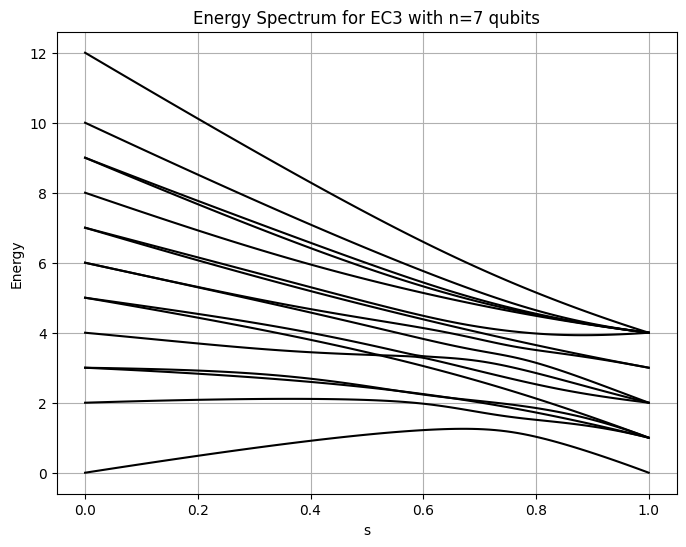

In [7]:
# Number of qubits
n_qubits = 4

clauses, satisfying_assignment = generate_ec3_instance(n_qubits)

# unique_solution = generate_random_solution(n_qubits)
# print(unique_solution)
# clauses = generate_unique_ec3_instance(n_qubits, 3, unique_solution)

print(f"Unique satisfying bitstring: {''.join(map(str, satisfying_assignment))}")

print(f"Generated EC3 clauses (n={n_qubits}):")
for clause in clauses:
    print(clause)
    

# Define single-qubit Pauli-X and Identity matrices
I = qeye(2)
I_7 = tensor([I for _ in range(n_qubits)])
X = sigmax()
Z = sigmaz()

def H_B(clauses):
    H_b = 0
    for (i, j, k) in clauses:
        H_b += 0.5 * (I_7 - tensor([X if x == i else I for x in range(n_qubits)]))
        H_b += 0.5 * (I_7 - tensor([X if x == j else I for x in range(n_qubits)]))
        H_b += 0.5 * (I_7 - tensor([X if x == k else I for x in range(n_qubits)]))
    return H_b

def check_clause_violation(state_binary, clause):
    i, j, k = clause
    bits = [state_binary[i], state_binary[j], state_binary[k]]
    return sum(bits) != 1

def cost_function(z, clauses):
    bitstring = f"{z:0{n_qubits}b}"
    bit_values = [int(b) for b in bitstring] 

    violations = 0
    for clause in clauses:
        if check_clause_violation(bit_values, clause):
            violations += 1  # Clause is violated

    return violations

# Problem Hamiltonian H_P
def H_P(clauses):
    H_p = 0
    for z in range(2**n_qubits):
        state = basis(2**n_qubits, z)

        h_z = cost_function(z, clauses)
        projector_z = state * state.dag()
        
        H_p += h_z * projector_z
    return H_p

def H_t(s, Hp, Hb):
    return (1 - s) * Hb + s * Hp

s_values = np.linspace(0, 1, 100)
Hb = H_B(clauses)
Hp = H_P(clauses)
Hb = Qobj(Hb.data, dims=Hp.dims)

energy_diff = None
# Calculate the energy spectrum
energy_spectrum = []
for s in s_values:
    H = H_t(s, Hp, Hb)
    energies = H.eigenenergies()
    energy_spectrum.append(energies)
    
    eg_inst = energies[1] - energies[0]
    if not energy_diff:
        energy_diff = eg_inst
    if energy_diff > eg_inst:
        energy_diff = eg_inst

print("Energy diff is: ", energy_diff)

energy_spectrum = np.array(energy_spectrum)
# Plot the energy spectrum
plt.figure(figsize=(8, 6))
for i in range(2**n_qubits):
    plt.plot(s_values, energy_spectrum[:, i], color='black')

plt.xlabel('s')
plt.ylabel('Energy')
plt.title('Energy Spectrum for EC3 with n=7 qubits')
plt.grid(True)
plt.show()

# Checking if the GS is the unique assignment

In [22]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def dissipator(ops, temperature, energy_diff, l):
    Nba = bose_einstein_distribution(energy_diff, temperature)
    factor = initial_gs.dag()*ops*final_gs*final_gs.dag()*ops.dag()*initial_gs
    return np.sqrt(l * Nba * factor.tr()) * ops
    # return np.sqrt(l * Nba) * ops

def H_s_t(t, Hp, Hb, t_max):
    s = t / t_max
    return (1 - s) * Hb + s * Hp

def rho_P(T):
    eigenvalues, eigenstates = Hp.eigenstates()
    Z = np.sum([np.exp(-ev / T) for ev in eigenvalues])
    # Thermal density matrix
    return sum([np.exp(-eigenvalues[i] / T) * eigenstates[i] * eigenstates[i].dag() for i in range(len(eigenstates))]) / Z

In [14]:
# Ground state of Hb at the beginning of the protocol |a>
initial_gs = Hb.groundstate()[1]
# Ground state of Hp at the ending of the protocol |b>
final_gs = Hp.groundstate()[1]

eigenvalues_final, eigenstates_final = Hp.eigenstates()
eigenvalues_initial, eigenstates_initial = Hb.eigenstates()

omega_ba = eigenvalues_final[0] - eigenvalues_initial[0]

solution_bitstring_index = np.argmax(np.abs(final_gs.full()))
print(solution_bitstring_index)
solution_bitstring = f"{solution_bitstring_index:0{n_qubits}b}"

print(f"Solution bitstring (EC3 solution): {solution_bitstring}")

4
Solution bitstring (EC3 solution): 0100


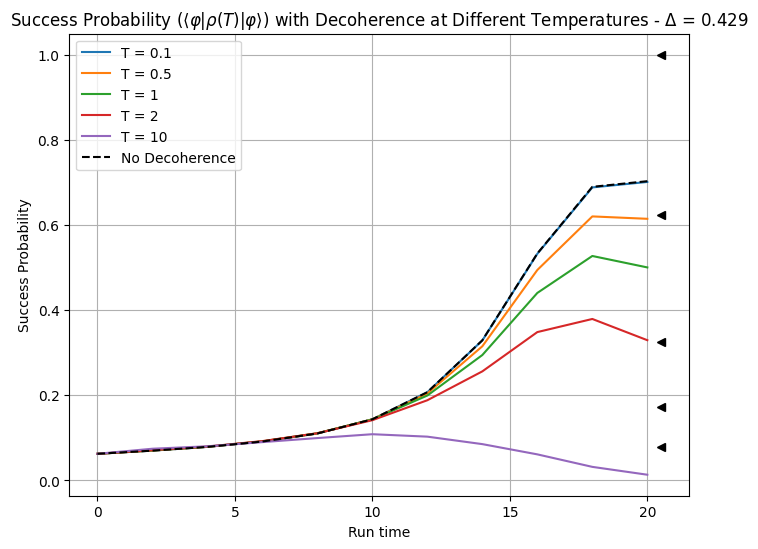

In [24]:
times = np.linspace(0, 20, 11)
s_values = times / max(times)

lambda_2 = 0.1

temperatures = [1/10, 1/2, 1, 2, 10]
# temperatures = [1/2, 1, 2, 10]

# Initial state (starting in the ground state of H_B)
rho0 = initial_gs * initial_gs.dag()

# Target state (ground state of H_P)
rho1 = final_gs * final_gs.dag()

# Solve the master equation for each temperature
plt.figure(figsize=(8, 6))
expects_at_end = []
for T in temperatures:
    c_ops = []
    
    # Collapse operators: include decoherence on each qubit
    for i in range(n_qubits):
        sigmam_i = Qobj(tensor([sigmam() if j == i else qeye(2) for j in range(n_qubits)]).data, dims=Hp.dims)  # Apply sigmam to qubit i
        c_ops.append(dissipator(sigmam_i, T, energy_diff, lambda_2))
        # c_ops.append(dissipator(sigmam_i, T, omega_ba, lambda_2))
        
    # Solve the master equation over time
    results = mesolve(lambda t, args: H_s_t(t, Hp, Hb, int(np.max(times))), rho0, times, c_ops)

    exps = []
    for state_dm in results.states:
        exps.append(expect(state_dm, final_gs))
    plt.plot(times, exps, label=f"T = {T}")  # Success probability
    
    #thermal success probabilities
    expects_at_end.append(expect(rho_P(T), final_gs))

x_s = [np.max(times) + 0.5 for _ in range(len(temperatures))]
plt.plot(x_s, expects_at_end, '<', color='black')

results_se = sesolve(lambda t, args: H_s_t(t, Hp, Hb, int(np.max(times))), initial_gs, times)
exps_se = []
for state in results_se.states:
    exps_se.append(expect(ket2dm(state), final_gs))
plt.plot(times, exps_se, '--', label="No Decoherence", color='black', linewidth=1.5)

# Plot formatting
plt.xlabel('Run time')
plt.ylabel('Success Probability')
plt.title('Success Probability (' + r"$\langle \varphi | \rho(T) | \varphi \rangle$" + ') with Decoherence at Different Temperatures - ' + r'$\Delta$' + ' = {}'.format(round(energy_diff,3)))
plt.legend()
plt.grid(True)
plt.show()